In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

# Used Cars Dataset
This dataset was uploaded to Kaggle by Orges Leka and is accessible under the url: https://www.kaggle.com/orgesleka/used-cars-database. He scraped over 371,713 used car listings from German *Ebay* Classified Ads. The content of the data is in German.

## What can we find out?
We will approach this data set from the perspective of a potential used car buyer. What is a good deal? To determine this, it becomes necessary to explore the following questions:

1. Does mileage effect the car price? Is the car with low mileage always going to be expensive?
2. Is there a correlation between the registration year and the car price?  Is a newer car always more expensive?
3. What are the chances of getting a good deal depending on the type of transmission?
4. How about fuel type? Do we have better chances with diesel or with gas?
5. How much time do we have as buyers to spot a great deal before it disappears from *Ebay*?

In [2]:
#Import the raw data
cars = pd.read_csv('C:\Inna\'s files\data\Cars\cars.csv', encoding='ISO-8859-1')
cars.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

In [3]:
cars.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,3/24/2016 11:52,Golf_3_1.6,privat,Angebot,480.0,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,3/24/2016 0:00,0,70435,4/7/2016 3:16
1,3/24/2016 10:58,A5_Sportback_2.7_Tdi,privat,Angebot,18300.0,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,3/24/2016 0:00,0,66954,4/7/2016 1:46
2,3/14/2016 12:52,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800.0,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,3/14/2016 0:00,0,90480,4/5/2016 12:47
3,3/17/2016 16:54,GOLF_4_1_4__3TÜRER,privat,Angebot,1500.0,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,3/17/2016 0:00,0,91074,3/17/2016 17:40
4,3/31/2016 17:25,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600.0,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,3/31/2016 0:00,0,60437,4/6/2016 10:17


In [4]:
#Change the data type of the columns
cars['dateCreated'] = pd.to_datetime(cars['dateCreated'])
cars['lastSeen'] = pd.to_datetime(cars['lastSeen'])
cars['price'] = pd.to_numeric(cars['price'], errors='coerce')
cars = cars.dropna(subset=['price'])                             
cars['price'] = cars['price'].astype(int)

Since we are approaching this data as potential buyers, we will only look at cars for sale ('Angebot') and not wanted ('Gesuch').

In [5]:
#Remove 'wanted'
cars = cars.drop(cars[cars['offerType'] != 'Angebot'].index)

Additionally, we will make the decision that we are not interested in purchasing a car with unrepaired damage, so we will only look at the corresponding subset of the data.

In [6]:
#Exclude the cars with not repaired damage
no_damage = cars.loc[lambda df: cars['notRepairedDamage'] == 'nein', :]

In [8]:
#Verify the data types of the columns
no_damage.dtypes

dateCrawled                    object
name                           object
seller                         object
offerType                      object
price                           int32
abtest                         object
vehicleType                    object
yearOfRegistration              int64
gearbox                        object
powerPS                         int64
model                          object
kilometer                       int64
monthOfRegistration             int64
fuelType                       object
brand                          object
notRepairedDamage              object
dateCreated            datetime64[ns]
nrOfPictures                    int64
postalCode                      int64
lastSeen               datetime64[ns]
dtype: object

In [9]:
no_damage.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,2.633140e+05,263314.000000,263314.000000,263314.000000,263314.000000,263314.0,263314.000000
mean,9.130037e+03,2004.126659,125.359924,123037.723023,6.140596,0.0,51511.622044
std,3.959994e+05,33.801479,168.193558,40559.612775,3.503986,0.0,25902.340202
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1.700000e+03,2000.000000,75.000000,100000.000000,3.000000,0.0,30989.000000
50%,3.999000e+03,2004.000000,116.000000,150000.000000,6.000000,0.0,50735.000000
75%,8.900000e+03,2009.000000,150.000000,150000.000000,9.000000,0.0,72535.000000
max,1.000000e+08,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [10]:
#There is a year value of 9999 which is not helpful for our analysis. We will remove this entry from the data. 
#Also, we will remove any data with years earlier than 1910 and over 2018 which are suspicious.
fixed_year = no_damage.loc[(no_damage['yearOfRegistration'] != 9999) &(no_damage['yearOfRegistration']> 1910) & (no_damage['yearOfRegistration']< 2019)]

The chart above shows us that minimum price is 0. We would like to get rid of all the listings that the price of 0 because they do not contribute to our analysis.

In [14]:
fixed_prices = fixed_year.loc[lambda df: fixed_year['price'] !=0, :]

Price is what interests us the most. We could compare the measures of central tendency:

In [15]:
print ('The mean price:')
print(np.mean(fixed_prices['price']))
print ('The median price:')
print(np.median(fixed_prices['price']))

The mean price:
9252.621237023723
The median price:
4050.0


The difference between the mean and median is very significant, which tells us that the mean is most likely affected by high outliers. 

We can use a boxplot to identify low price outliers. For our purposes, we will further examine cars that fall into the lower 75% of the percentage (first three quartiles) or under 8,900. These cars we will deem as affordable. 

In [18]:
affordable = fixed_prices.loc[lambda df: with_prices['price'] < 8900, :]

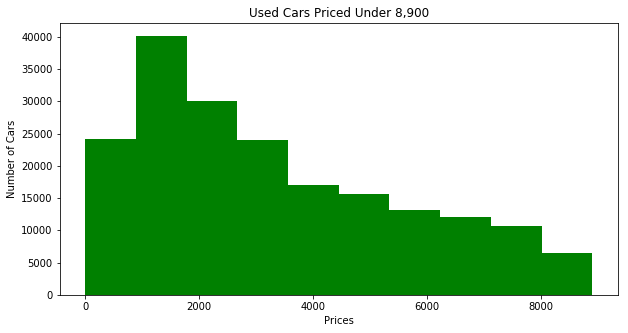

In [23]:
plt.figure(figsize=(10,5))
plt.hist(affordable['price'], color='g')
plt.title('Used Cars Priced Under 8,900')
plt.xlabel('Prices')
plt.ylabel('Number of Cars')
plt.show()

If we look at the distribution of the used cars under 8,900 we will immediately realize that the price distribution is not normal.

In [24]:
affordable.corr()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
price,1.000000,0.388099,0.118681,-0.259392,0.057057,NaN,0.046264
yearOfRegistration,0.388099,1.000000,0.000168,-0.176807,0.003062,NaN,0.001365
powerPS,0.118681,0.000168,1.000000,0.054066,0.011790,NaN,0.015789
kilometer,-0.259392,-0.176807,0.054066,1.000000,0.001887,NaN,0.007179
monthOfRegistration,0.057057,0.003062,0.011790,0.001887,1.000000,NaN,0.003811
nrOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postalCode,0.046264,0.001365,0.015789,0.007179,0.003811,NaN,1.000000


Next, we will turn to mileage. As buyers, we are interested in buying a car with lower mileage. The boxplot of mileage shows us that our data has a few low outliers: used cars with mileage under 40,000 kilometers (or approx. 24854.85 miles). It seems that there is a negative correlation between price and mileage.

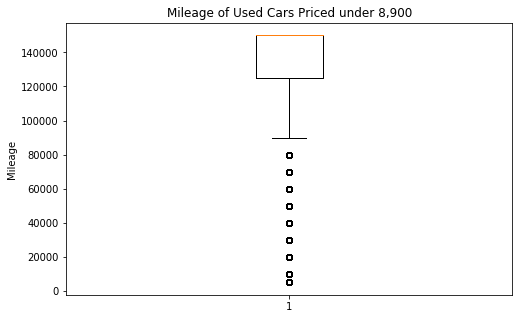

In [27]:
plt.figure(figsize=(8,5))
plt.boxplot(affordable['kilometer'])
plt.title('Mileage of Used Cars Priced under 8,900')
plt.ylabel('Mileage')
plt.show()

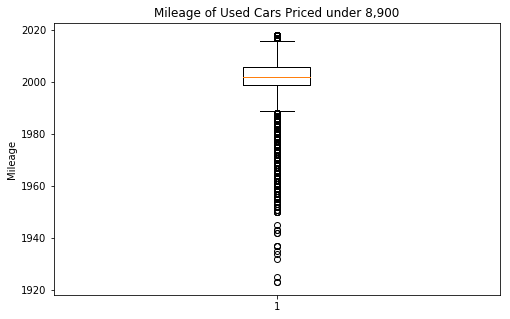

In [29]:
plt.figure(figsize=(8,5))
plt.boxplot(affordable['yearOfRegistration'])
plt.title('Mileage of Used Cars Priced under 8,900')
plt.ylabel('Mileage')
plt.show()

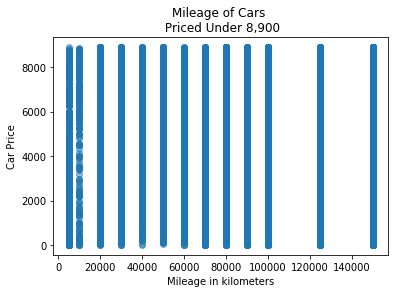

In [32]:
plt.scatter(x=affordable['kilometer'], y=affordable['price'], alpha=.5)
plt.title('Mileage of Cars \n Priced Under 8,900')
plt.xlabel('Mileage in kilometers')
plt.ylabel('Car Price')
plt.show()

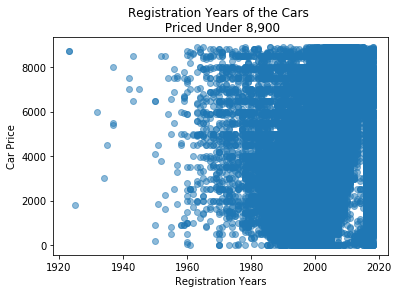

In [33]:
plt.scatter(x=affordable['yearOfRegistration'], y=affordable['price'], alpha=.5)
plt.title('Registration Years of the Cars \n Priced Under 8,900')
plt.xlabel('Registration Years')
plt.ylabel('Car Price')
plt.show()